In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy

import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
import geopandas
import cartopy.io.shapereader as shpreader
import shapely

In [2]:
places = pd.read_csv('../data/place_df.csv')

In [53]:
degrees = 2.5
tdf = pd.read_csv(f'../data/study_da_6 - Temperature - upper_pred_{degrees}.csv')
tdf["da_var"] = "Temperature"
pdf = pd.read_csv(f'../data/study_da_6 - Precipitation - upper_pred_{degrees}.csv')
pdf["da_var"] = "Precipitation"

df = pd.concat([tdf,pdf])

df = df[pd.notna(df["gridcells"]) & df["gridcells"]>0]

df["da_trend_p"] = df["da_trend_cells"] / df["gridcells"]

df.shape

(13263, 325)

In [54]:
places = pd.read_csv('../data/place_df.csv')

import pycountry_convert as pc
def get_cont(x):
    continents = {
        'NA': 'North America',
        'SA': 'South America', 
        'AS': 'Asia',
        'OC': 'Oceania',
        'AF': 'Africa',
        'EU': 'Europe'
    }
    try:
        return continents[pc.country_alpha2_to_continent_code(pc.country_alpha3_to_country_alpha2(x['country_predicted']))]
    except:
        return None
places['continent'] = places.apply(lambda x: get_cont(x), axis=1)
other_country_continents = [
    ("ESH","Africa"),
    ("TLS","Oceania"),
    ("XKX","Europe")
    
]
for country,continent in other_country_continents:
    places.loc[places['country_predicted']==country,"continent"] = continent
places.head()

,Unnamed: 0,word,spans,country_predicted,country_conf,geo,doc_id,lat,lon,feature_code,geonameid,place_name,feature_class,continent
0,0,United States,"[{'start': 427, 'end': 440}]",USA,0.999811,"{'admin1': 'NA', 'lat': '39.76', 'lon': '-98.5...",3305893,39.76,-98.5,PCLI,6252001,United States,A,North America
1,3,India,"[{'start': 140, 'end': 145}]",IND,0.999398,"{'admin1': 'NA', 'lat': '22', 'lon': '79', 'co...",1477550,22.00,79.0,PCLI,1269750,Republic of India,A,Asia
2,4,Russia,"[{'start': 697, 'end': 703}]",RUS,0.999401,"{'admin1': 'NA', 'lat': '60', 'lon': '100', 'c...",1477550,60.00,100.0,PCLI,2017370,Russian Federation,A,Europe
3,5,Pakistan,"[{'start': 763, 'end': 771}]",PAK,0.989610,"{'admin1': 'Punjab', 'lat': '31.4706', 'lon': ...",1477550,30.00,70.0,PCLI,1168579,Islamic Republic of Pakistan,A,Asia
4,8,Cameroon,"[{'start': 213, 'end': 221}]",CMR,0.999931,"{'admin1': 'NA', 'lat': '6', 'lon': '12.5', 'c...",1336166,6.00,12.5,PCLI,2233387,Republic of Cameroon,A,Africa


In [55]:
sector_cols = [x for x in df.columns if "12 - " in x and " - upper_pred" in x]

<ipython-input-63-dcf8a7df9304>:9: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_linewidth(0.2)


Africa
Asia
Europe
North America
Oceania
South America


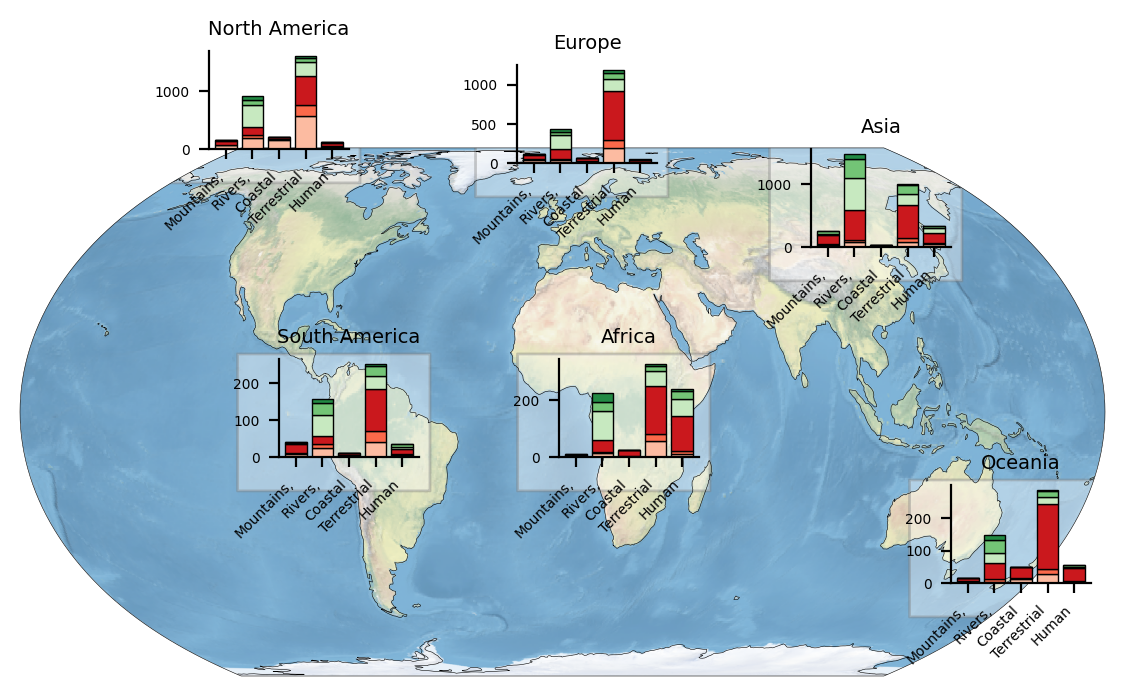

In [63]:
import cartopy.io.img_tiles as cimgt
from matplotlib.patches import FancyBboxPatch


stamen_terrain = cimgt.Stamen('terrain-background')

fig = plt.figure(dpi=200, figsize=(7,7))
ax = plt.axes(projection=ccrs.EqualEarth())
ax.outline_patch.set_linewidth(0.2)
ax.coastlines(lw=0.2)

#ax.add_image(stamen_terrain, 1)

ax.stock_img()

regions = [
    {"name": "Africa", "x": 0.51, "y": 0.47},
    {"name": "Asia", "x": 0.69, "y": 0.62},
    {"name": "Europe",    "x": 0.48,    "y": 0.68},
    {"name": "North America", "x": 0.26, "y": 0.69},
    {"name": "Oceania", "x": 0.79, "y": 0.38},
    {"name": "South America", "x": 0.31, "y": 0.47},
    
#     {"name": "Global or NA", "x": 0.44, "y": 0.29, "alpha":1}
]

colors = ["Reds","Greens","Oranges","Purples","Reds","PuRd","YlGnBu"]

lw = 0.5

cols = 2

for ci, (continent, group) in enumerate(places.groupby('continent')):
    print(continent)
    r = regions[ci]
    a = plt.axes([r["x"],r["y"], .1, .07], transform=ccrs.PlateCarree())
    a.set_facecolor("none")
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
    
    fig.canvas.draw_idle()
    ex = a.get_tightbbox(fig.canvas.get_renderer())
    xy = ax.transData.inverted().transform((ex.x0, ex.y0))
    x2y2 = ax.transData.inverted().transform((ex.x1, ex.y1))

    if "alpha" in r:
        alpha=r["alpha"]
    else:
        alpha=0.4

    p_fancy = FancyBboxPatch(xy,
         x2y2[0]-xy[0], x2y2[1]-xy[1],
         boxstyle="round,pad=3",
         alpha=alpha,
         fc="white",
         ec="grey"
    )
    
    ax.add_patch(p_fancy)
    
    vdf = df[df["id"].isin(group["doc_id"])]
    
    for i, col in enumerate(sector_cols):

        b = 0
        all_handles = []
        for j, da_var in enumerate(["Temperature","Precipitation"]):

            cm = mpl.cm.get_cmap(colors[j])

            cdf = vdf[(vdf[col]>0.5) & (vdf["da_var"]==da_var) ]

            y = cdf[cdf['da_trend_p']==0].shape[0]
            l1 = a.bar(i, y, bottom=b, edgecolor="black",lw=lw,color=cm(0.25))   
            b+=y

            y = cdf[(cdf['da_trend_p']>0) & (cdf['da_trend_p']<0.5)].shape[0]
            l2 = a.bar(i, y, bottom=b, edgecolor="black",lw=lw, color=cm(0.5))    
            b+=y

            y = cdf[(cdf['da_trend_p']>0.5)].shape[0]
            l3 = a.bar(i, y, bottom=b, edgecolor="black",lw=lw, color=cm(0.75))  
            b+=y
            
            var_handles = [l1,l2,l3]
            all_handles.append(var_handles)
            
    ticks, ticklabels = zip(*[(i, x.split(' - ')[1].split()[0]) for i, x in enumerate(sector_cols)])
    a.set_xticks(ticks)
    a.set_xticklabels(ticklabels, rotation=45, ha="right")
        
    a.set_title(continent, fontsize=7)
        
    a.tick_params(axis='both', which='major', labelsize=5)

In [103]:
ndf = pd.read_csv('../data/gridcell_studies_all_2.5.csv')
ndf.head()

,LAT,LON,n_studies,LAT_25,LON_25,da_cat,index,n_study_prop
0,-88.75,181.25,0.0,-87.5,182.5,NaN,0,0.001667
1,-88.75,183.75,0.0,-87.5,182.5,NaN,1,0.001667
2,-88.75,186.25,0.0,-87.5,187.5,NaN,4,0.001667
3,-88.75,188.75,0.0,-87.5,187.5,NaN,5,0.001667
4,-88.75,191.25,0.0,-87.5,192.5,NaN,8,0.001667


South America
(0.32, 0.35)
North America
(0.3, 0.8)
Africa
(0.5, 0.6)
Europe
(0.2, 0.2)
Asia
(0.2, 0.2)
Oceania
(0.2, 0.2)


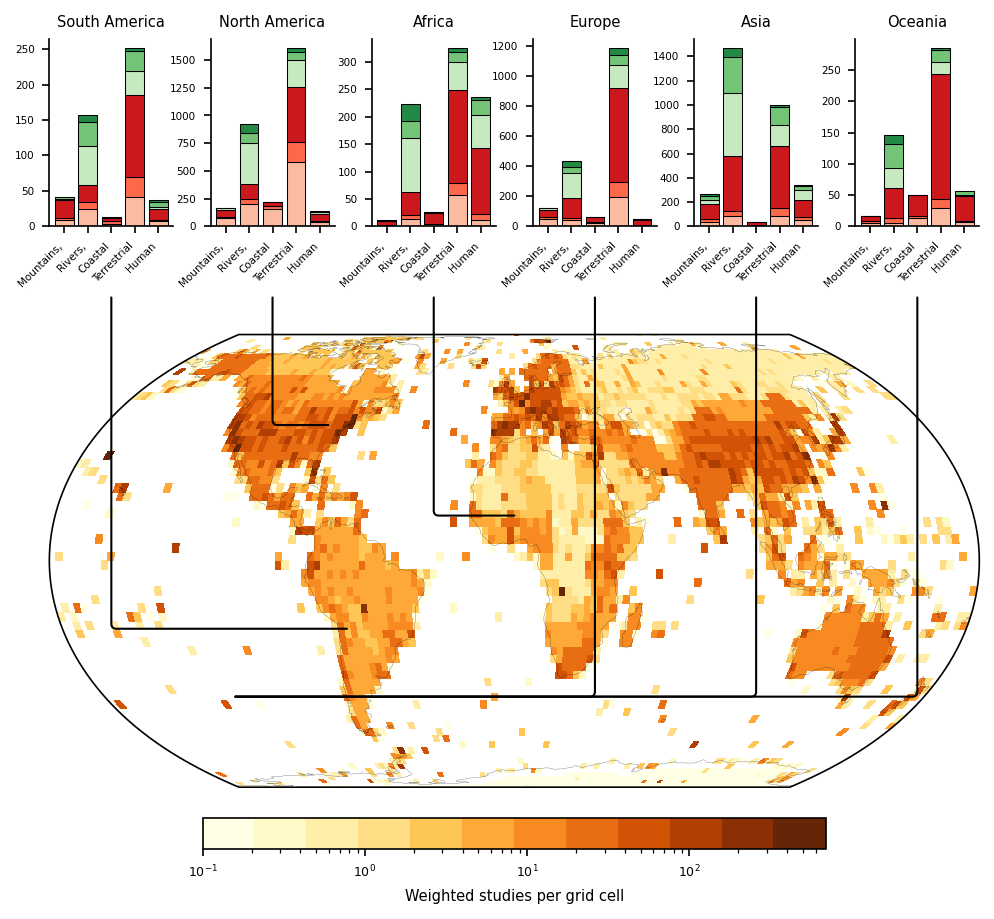

In [198]:
import matplotlib.gridspec as gridspec
from matplotlib.patches import ConnectionPatch, ConnectionStyle

fig = plt.figure(dpi=150,figsize=(8,6))

gs = gridspec.GridSpec(2, 6, height_ratios=[.3, 1,], bottom=.05, top=.95, wspace=.3, hspace=0.0)

ax = plt.subplot(gs[1, :], projection=ccrs.EqualEarth())

ndf.loc[ndf['LON']>180,"LON"]-=360

n = np.array(ndf.n_study_prop).reshape(len(ndf.LAT.unique()), len(ndf.LON.unique()))
vm = n.max()
n[n==0] = np.nan

ax.coastlines(lw=0.1)
mesh = ax.pcolormesh(
    X,
    Y,
    n,
    norm = mpl.colors.LogNorm(vmin=0.1, vmax=vm),
    cmap=plt.cm.get_cmap('YlOrBr',12), 
    transform=ccrs.PlateCarree(),
    #shading="gouraud"
)
cbar = plt.colorbar(mesh, orientation="horizontal", fraction=0.05, pad=0.05)

cbar.set_label("Weighted studies per grid cell", fontsize=7)
cbar.ax.tick_params(labelsize=6)

continents = [
    "South America", 
    "North America", 
    "Africa", 
    "Europe", 
    "Asia",
    "Oceania"
]

continent_labels = [
    (0.32,0.35),
    (0.3,0.8),
    (0.5,0.6),
    (0.2,0.2),
    (0.2,0.2),
    (0.2,0.2),
]

#for ci, (continent, group) in enumerate(places.groupby('continent')):
    
for ci, continent in enumerate(continents):
    group = places[places["continent"]==continent]
    print(continent)
    r = regions[ci]
    a = plt.subplot(gs[0,ci])
    a.set_facecolor("none")
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
    
    
    xy = (0.5, -0.38)
    
    mxy = continent_labels[ci]
    print(mxy)
    con = ConnectionPatch(xyA=xy, coordsA=a.transAxes,
                          xyB=mxy, coordsB=ax.transAxes,
                          connectionstyle=ConnectionStyle.Angle(angleA=90, rad=5)
                         )
    fig.add_artist(con)

    
    vdf = df[df["id"].isin(group["doc_id"])]
    
    for i, col in enumerate(sector_cols):

        b = 0
        all_handles = []
        for j, da_var in enumerate(["Temperature","Precipitation"]):

            cm = mpl.cm.get_cmap(colors[j])

            cdf = vdf[(vdf[col]>0.5) & (vdf["da_var"]==da_var) ]

            y = cdf[cdf['da_trend_p']==0].shape[0]
            l1 = a.bar(i, y, bottom=b, edgecolor="black",lw=lw,color=cm(0.25))   
            b+=y

            y = cdf[(cdf['da_trend_p']>0) & (cdf['da_trend_p']<0.5)].shape[0]
            l2 = a.bar(i, y, bottom=b, edgecolor="black",lw=lw, color=cm(0.5))    
            b+=y

            y = cdf[(cdf['da_trend_p']>0.5)].shape[0]
            l3 = a.bar(i, y, bottom=b, edgecolor="black",lw=lw, color=cm(0.75))  
            b+=y
            
            var_handles = [l1,l2,l3]
            all_handles.append(var_handles)
            
    ticks, ticklabels = zip(*[(i, x.split(' - ')[1].split()[0]) for i, x in enumerate(sector_cols)])
    a.set_xticks(ticks)
    a.set_xticklabels(ticklabels, rotation=45, ha="right")
        
    a.set_title(continent, fontsize=7)
        
    a.tick_params(axis='both', which='major', labelsize=5)
    

    
plt.savefig('../plots/maps/study_type_continent.png')

In [130]:
X, Y = np.meshgrid(
    list(ndf.LON.unique()-degrees*0.5)+[ndf.LON.max()+degrees*0.5],   
    list(ndf.LAT.unique()-degrees*0.5)+[ndf.LAT.max()+degrees*0.5], 
)
X.shape

(73, 145)

In [128]:
n.shape

(72, 144)

In [90]:
[x.shape for x in np.meshgrid(    ndf.LON.unique()-degrees*0.5,    ndf.LAT.unique()-degrees*0.5,)]

[(72, 144), (72, 144)]